In [ ]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [1]:
import os
import sys
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
from tqdm.notebook import tqdm
from torchmetrics import JaccardIndex
jaccardidx = JaccardIndex(task="BINARY")
jaccardidx.__name__ = 'JaccardIndex'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
work_dir = "/content/drive/MyDrive/Deep_learning_course/Lung_segmentation/segmentation_problem/"
sys.path.append(work_dir)

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [4]:
from unet_model import CustomUnet
from custom_load import LungDatasetSeg, LungDatasetLoaderTest

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


### Move data to localpath

In [5]:
path_to_zip_folder = '/content/drive/MyDrive/Deep_learning_course/Lung_segmentation/data/m3ex02-data.zip'
current_folder_path = '/content/localpath/'
!unzip -q $path_to_zip_folder -d $current_folder_path

### Define parameters

In [7]:
# data parameters
data_path: str = '/content/localpath/m3ex02-data/'
path_test: str = os.path.join(data_path, 'Test/')
path_train: str = os.path.join(data_path, 'Train/')
path_eval: str = os.path.join(data_path, 'Val/')
# training parameters
batch_size: int = 150
workers: int = 8
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model parameters
path_load: str = '/content/drive/MyDrive/Deep_learning_course/Lung_segmentation/segmentation_problem/models/'
name_load: str = 'covid_segmentation_2.pkl'
in_channels: int = 1
out_channels: int = 1

### Load data

In [8]:
data_test = LungDatasetLoaderTest(
    path_test,
    batch_size=batch_size,
    workers=workers,
    pin_memory_device=device
)

### Load pre-trained models

In [ ]:
jaccardidx.to(device)

BinaryJaccardIndex()

In [ ]:
# unet. a pretrained model is used
model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=in_channels, out_channels=in_channels, init_features=32, pretrained=False
)
state = torch.load(os.path.join(path_load, name_load))
model.load_state_dict(state["model"])
model = model.to(device)

In [ ]:
model = CustomUnet(in_channels=in_channels)
state = torch.load(os.path.join(path_load, name_load))
model.load_state_dict(state["model"])
model = model.to(device)
#  map_location=torch.device('cpu')

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
def test_model(model_, data_test):
  tot = len(data_test)
  model_.to(device)
  model_.eval()
  with torch.no_grad():
    test_metrics = []

    for i, (batch) in tqdm(enumerate(data_test), total=tot):
      batch_x = batch["image"].to(device)
      batch_y = batch["mask"].to(device)

      y_pred = model_(batch_x)

      rcl = jaccardidx(y_pred, batch_y)

      test_metrics.append(rcl.detach().cpu().numpy())

    test_metrics = np.mean(test_metrics, axis=0)

  return test_metrics

In [ ]:
data_test.dataset[0]["image"].shape

torch.Size([1, 256, 256])

In [ ]:
def plot_image_mask(model, data, index):
  X = data.dataset[index]
  image = X["image"]
  image_ = image.unsqueeze(0)
  image_ = image_.to(device)
  model = model.to(device)
  model.eval()
  with torch.no_grad():
    y_pred = model(image_)
  mask = y_pred[0] > 0.5
  mask = mask.cpu().numpy()
  plt.imshow(image[0])
  plt.imshow(mask[0], alpha=0.5)

In [ ]:
output = test_model(model, data_test)

In [ ]:
output

0.931884

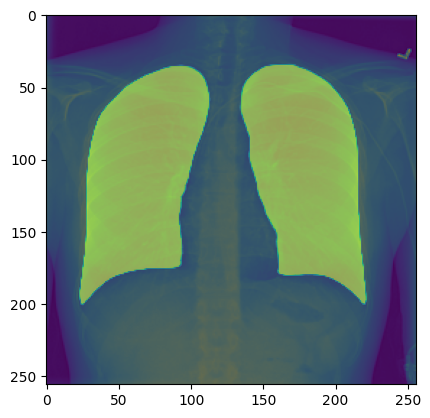

In [ ]:
plot_image_mask(model, data_test, 150)